# 転移学習の実装
VGG-16モデルをさらに学習させ，アリとハチの画像を分類  
転移学習によって，少ないデータでも良い結果を出せる

## フォルダ準備，事前準備
1-1でデータのダウンロードを済ませておく  
pip install tqdm

## 実装の初期設定

In [1]:
import glob
import os
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

GPUを使用しても完全に同じ結果を再現したい場合は以下の設定を行う．  
しかし，この設定を入れると遅くなるので今回は設定しない．

In [3]:
# torch.bachends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

## Datasetを作成
- 画像の前処理
- 前処理済み画像をリストに格納
- HymenopteraDatasetクラスを作成

訓練時にはデータオーギュメンテーションを行う  
- RandomResizedCrop
    - 0.5~1.0で画像を拡大/縮小
    - アスペクト比を3/4~4/3のいずれかで変更
    - resizeで指定したサイズにする
- RandomHorizontalFlip
    - 50%で左右反転

torchvision.datasets.ImageFolderクラスというものもあるが今回は使わない

In [4]:
class ImageTransform():
    """
    画像の前処理＋DataAug
    
    Attributes
    ----------
    resize: int
        リサイズ先の大きさ
    mean: (R, G, B)
        各色チャネルの平均値
    std: (R, G, B)
        各色チャネルの標準偏差
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)
                ), # DataAug
                transforms.RandomHorizontalFlip(), # DataAug
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase="train"):
        """
        Parameters
        ----------
        phase: 'train' or 'val'
            前処理のモードを指定
        """
        return self.data_transform[phase](img)
        

In [5]:
data_dir = "../../datasets/ptca_datasets/chapter1"
image_net_path = os.path.join(data_dir, "imagenet_class_index.json")
hymenoptera_path = os.path.join(data_dir, "hymenoptera_data")

犬の画像で動作確認

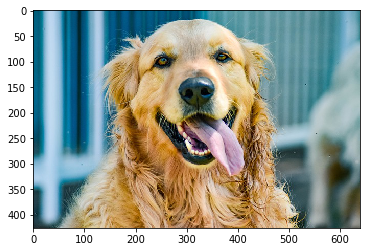

In [6]:
image_file_path = os.path.join(data_dir, "goldenretriever-3724972_640.jpg")
img = Image.open(image_file_path)
plt.imshow(img)

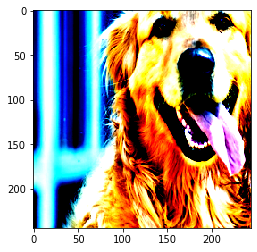

In [7]:
resize = 244
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img) # TorchTensor (3, 224, 224)
img_transformed = img_transformed.numpy().transpose((1, 2, 0)) # (H, W, C)
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)

データへのファイルパスを格納したリスト変数を作成

In [8]:
def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する
    
    Parameters
    ----------
    phase: 'train' or 'val'
        訓練データか検証データかを指定する
    
    Returns
    -------
    path_list: list
        データへのパスを格納したリスト
    """
    
    rootpath = hymenoptera_path
    target_path = osp.join(f"{rootpath}/{phase}/**/*.jpg")
    print(target_path)
    
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [9]:
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")
train_list[:5]

../datasets/chapter1/hymenoptera_data/train/**/*.jpg
../datasets/chapter1/hymenoptera_data/val/**/*.jpg


['../datasets/chapter1/hymenoptera_data/train/bees/154600396_53e1252e52.jpg',
 '../datasets/chapter1/hymenoptera_data/train/bees/3030189811_01d095b793.jpg',
 '../datasets/chapter1/hymenoptera_data/train/bees/354167719_22dca13752.jpg',
 '../datasets/chapter1/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg',
 '../datasets/chapter1/hymenoptera_data/train/bees/444532809_9e931e2279.jpg']

最後にDatasetのクラスを作成

In [10]:
class HymenopteraDataset(data.Dataset): # PytorchのDatasetクラスを継承
    """
    アリとハチの画像のDatasetクラス
    
    Attributes
    ----------
    file_list: リスト
        画像のパスを格納したリスト
    transform: object
        前処理クラスのインスタンス
    phase: 'train' or 'test'
        学習データかテストデータかを指定する
    """
    
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split(os.sep)[-2]
        
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label

In [11]:
train_dataset = HymenopteraDataset(
    file_list=train_list,
    transform=ImageTransform(resize, mean, std),
    phase="train"
)

val_dataset = HymenopteraDataset(
    file_list=val_list,
    transform=ImageTransform(resize, mean, std),
    phase="val"
)

torch.Size([3, 244, 244])
1


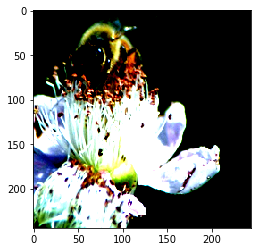

In [12]:
index = 0
item = train_dataset.__getitem__(index)
print(item[0].size())
print(item[1])

im = item[0].numpy().transpose((1, 2, 0)) # (H, W, C)
im = np.clip(im, 0, 1)
plt.imshow(im)

## DataLoaderを作成
Datasetからシャッフルして/しないでミニバッチを作るDataLoaderを作成  
torchのDataLoaderを使用する

In [13]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

dataloaders_dict = {
    "train": train_dataloader,
    "val": val_dataloader
}

動作確認  
訓練データのミニバッチを一つ取得

In [14]:
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 244, 244])
tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0])


## ネットワークモデルを作成
VGG-16モデルを使用して転移学習  
出力層に4096->2の全結合層を加え，アリかハチかの2択にする

In [15]:
# VGG-16の学習済みモデルを使用
net = models.vgg16(pretrained=True)

# 2択の全結合層を加える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モード
net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.6MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 損失関数の定義
クロスエントロピー誤差  
(ソフトマックス→negative log)

In [16]:
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定
まずは学習するパラメータとしないパラメータを決める．  
featuresは学習を行わず，classifierのみを学習させる

In [17]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print("----------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
----------------
[Parameter containing:
tensor([[ 0.0117,  0.0116,  0.0082,  ..., -0.0072,  0.0059, -0.0065],
        [-0.0071, -0.0131, -0.0117,  ..., -0.0079, -0.0070,  0.0085]],
       requires_grad=True), Parameter containing:
tensor([-0.0087,  0.0008], requires_grad=True)]


その後，最適化のアルゴリズムとしてMomentum SGDを使用させる．  
更新する必要のあるパラメータを渡す

In [18]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## 学習・検証を実施
epochごとに学習と検証を交互に実施  
学習時はtrainモード，検証時はevalモードにする  
ミニバッチごとに合計損失を求める

In [19]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("--------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            epoch_size = len(dataloaders_dict[phase].dataset)
            
            # 未学習時の検証性能を確かめるため，最初の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue
            
            # ミニバッチごとに学習を行う
            # tqdm: means "progress" in Arabic (taqadum)
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                
                    # 訓練時は誤差逆伝播で勾配を取得して重みの更新を行う
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # ミニバッチのLossと正解数をepochのものに追加
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            # item一つごとの平均Lossと平均正解数
            epoch_loss = epoch_loss / epoch_size
            epoch_acc = epoch_corrects.double() / epoch_size
            
            # Epochのステータス
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

学習を実行

In [20]:
num_epochs = 2
train_model(
    net, 
    dataloaders_dict, 
    criterion, 
    optimizer, 
    num_epochs=num_epochs
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
--------------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.8034936996067271 Acc: 0.3464052287581699
Epoch 2/2
--------------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.5206398680622195 Acc: 0.7407407407407407


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]

val Loss: 0.20150963874424205 Acc: 0.9215686274509803


2epoch目では訓練データの正答率の方が検証データの正答率より低い  
- 訓練データのイテレーション中は性能が上がっているので平均すると低くなる
    - そしたら最後の正答率を表示するべきでは？
- 訓練データにはDataAugを行なったものが含まれているため